In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

from matplotlib import rcParams

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('default')  

sc.settings.set_figure_params(dpi=80)


scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


... reading from cache file ./cache/projects-nehard-SingleCell-SLE-SLEvsHY-2019-SLE_agg_map-outs-filtered_gene_bc_matrices_mex-hg19-matrix.h5ad


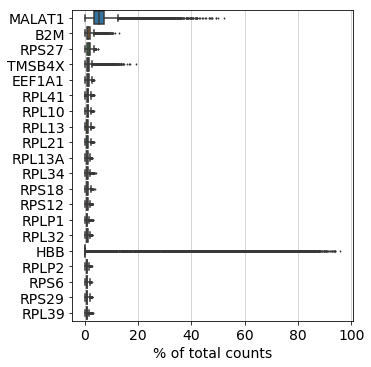

In [3]:
#--- read raw data (10X output)

adata = sc.read_10x_mtx('/projects/nehard/SingleCell/SLE/SLEvsHY/2019/SLE_agg_map/outs/filtered_gene_bc_matrices_mex/hg19/', var_names='gene_symbols', cache=True)

#---- Highly variabe genes 
adata.var_names_make_unique()
sc.pl.highest_expr_genes(adata, n_top=20)


In [6]:
adata

AnnData object with n_obs × n_vars = 283857 × 32738 
    var: 'gene_ids'

In [8]:
#---- filtring (number of cells, number of genes/cell)
sc.pp.filter_cells(adata, min_genes=400) #***
sc.pp.filter_genes(adata, min_cells=3)

#---- calculate mitochndrial content 
adata.var["mito"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, feature_conmtrols=["mito"], inplace=True)


filtered out 4967 cells that have less than 400 genes expressed
filtered out 9310 genes that are detected in less than 3 cells


In [9]:
adata

AnnData object with n_obs × n_vars = 278890 × 23428 
    obs: 'n_genes', 'total_features_by_counts', 'log1p_total_features_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_features', 'pct_counts_in_top_100_features', 'pct_counts_in_top_200_features', 'pct_counts_in_top_500_features', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'gene_ids', 'n_cells', 'mito', 'mean_counts', 'log1p_mean_counts', 'n_cells_by_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

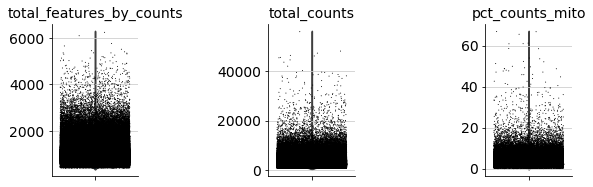

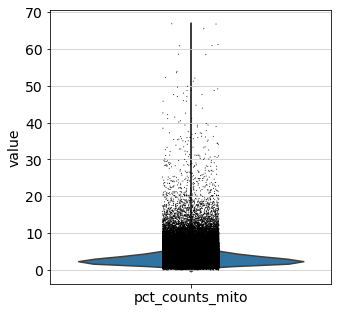

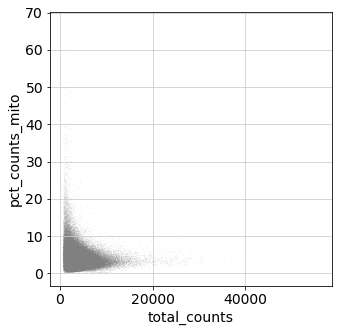

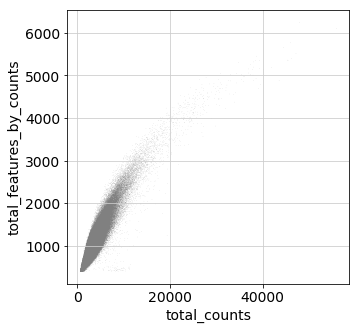

In [10]:
#----  QC plots + filtration

rcParams['figure.figsize'] = (5,5)
sc.pl.violin(adata, ['total_features_by_counts', 'total_counts', 'pct_counts_mito'],jitter=0.4, multi_panel=True)

rcParams['figure.figsize'] = (5,5)
sc.pl.violin(adata, [ 'pct_counts_mito'])
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mito')
sc.pl.scatter(adata, x='total_counts', y='total_features_by_counts')

#-- filtering: number of genes and % mito
adata = adata[adata.obs['total_features_by_counts'] < 2500, :]
adata = adata[adata.obs['pct_counts_mito'] < 20, :] #-- 20% mito 


In [30]:
adata

AnnData object with n_obs × n_vars = 275588 × 23428 
    obs: 'n_genes', 'total_features_by_counts', 'log1p_total_features_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_features', 'pct_counts_in_top_100_features', 'pct_counts_in_top_200_features', 'pct_counts_in_top_500_features', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'gene_ids', 'n_cells', 'mito', 'mean_counts', 'log1p_mean_counts', 'n_cells_by_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [31]:
results_file = './pSLEvsHD_Scrub_Raw_042519.h5ad' 

In [32]:
#-- save raw data object 

adata.write(results_file)

In [2]:
adata=sc.read(results_file)

In [1]:
#---- read the object after scrublet doublet removal on each invidual 

corrected_Scrub_BS = sc.read('./SLE_2nd_aggregated_scrubletBySample.h5ad')
corrected_Scrub_BS


In [17]:
#--- Define threshold to be applyed + define doublet vs. singlet

threshold = 0.18
corrected_Scrub_BS.obs['predicted_doublets_1'] = pd.Categorical(['doublet' if x > threshold else 'singlet' for x in corrected_Scrub_BS.obs.doublet_scores])
#- number of doublet and singlets 
corrected_Scrub_BS.obs.predicted_doublets_1.value_counts()


singlet    258868
doublet     16720
Name: predicted_doublets_1, dtype: int64

In [18]:
#---- extarct cell predicted as singlets 

cells_of_interest1 = corrected_Scrub_BS.obs.loc[corrected_Scrub_BS.obs["predicted_doublets_1"].isin(["singlet"]), :].index
cells_of_interest1

Index(['AAACCTGAGAGCCCAA-1', 'AAACCTGAGCAGGCTA-1', 'AAACCTGCACATAACC-1',
       'AAACCTGCAGAGTGTG-1', 'AAACCTGCATATGGTC-1', 'AAACCTGCATCTATGG-1',
       'AAACCTGGTATAAACG-1', 'AAACCTGGTCGATTGT-1', 'AAACCTGTCAAAGTAG-1',
       'AAACCTGTCGAACTGT-1',
       ...
       'TTTGTCACAGGGTTAG-44', 'TTTGTCACATCCGCGA-44', 'TTTGTCAGTAGCTCCG-44',
       'TTTGTCAGTCGGCACT-44', 'TTTGTCAGTGCCTGTG-44', 'TTTGTCAGTTCAGTAC-44',
       'TTTGTCAGTTCGGCAC-44', 'TTTGTCATCAAACGGG-44', 'TTTGTCATCGCATGAT-44',
       'TTTGTCATCGGTGTCG-44'],
      dtype='object', name='index', length=258868)

In [35]:
#------ Exctact object with singlet only 

adata_Scrub=adata[cells_of_interest1, :]
adata_Scrub

View of AnnData object with n_obs × n_vars = 258868 × 23428 
    obs: 'n_genes', 'total_features_by_counts', 'log1p_total_features_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_features', 'pct_counts_in_top_100_features', 'pct_counts_in_top_200_features', 'pct_counts_in_top_500_features', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'gene_ids', 'n_cells', 'mito', 'mean_counts', 'log1p_mean_counts', 'n_cells_by_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [ ]:
#--- Logarithmize the data
adata_Scrub.raw = sc.pp.log1p(adata_Scrub, copy=True)
#--- Per-cell normalize (library-size correct) the data matrix X, so that counts become comparable among cells.
sc.pp.normalize_per_cell(adata_Scrub, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(adata_Scrub.X, min_mean=0.0125, max_mean=3, min_disp=0.5)


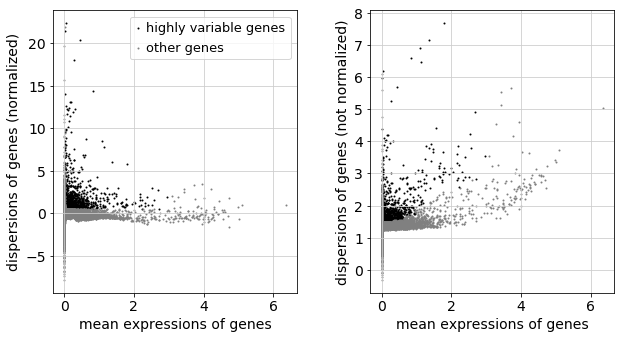

In [38]:
#--- Identify highly-variable genes
sc.pl.filter_genes_dispersion(filter_result)


In [39]:
results_file1= './pSLEvsHD_Scrub_BC_042519.h5ad' 

In [40]:
adata_Scrub = adata_Scrub[:, filter_result.gene_subset]
sc.pp.regress_out(adata_Scrub, ['total_counts', 'pct_counts_mito'])
sc.pp.scale(adata_Scrub, max_value=10)
adata_Scrub.write(results_file1)



regressing out ['total_counts', 'pct_counts_mito']
    sparse input is densified and may lead to high memory use
    finished (0:06:25.20)


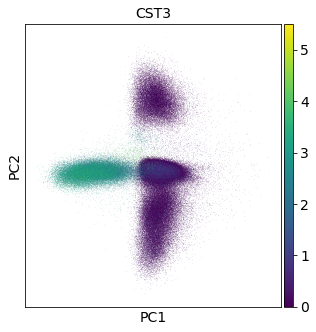

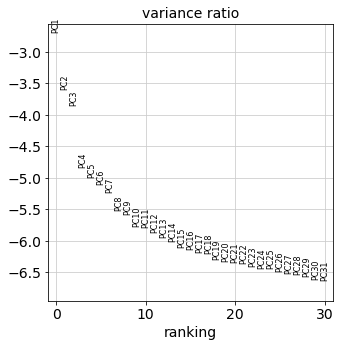

In [41]:
#-- PCA
sc.tl.pca(adata_Scrub, svd_solver='arpack')
sc.pl.pca(adata_Scrub, color='CST3')


sc.pl.pca_variance_ratio(adata_Scrub, log=True)

In [42]:
adata_Scrub.write(results_file1)
adata_Scrub


AnnData object with n_obs × n_vars = 258868 × 1205 
    obs: 'n_genes', 'total_features_by_counts', 'log1p_total_features_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_features', 'pct_counts_in_top_100_features', 'pct_counts_in_top_200_features', 'pct_counts_in_top_500_features', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'mito', 'mean_counts', 'log1p_mean_counts', 'n_cells_by_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [43]:

adata_Scrub = sc.read(results_file1)

#- Computing the neighborhood graph
sc.pp.neighbors(adata_Scrub, n_neighbors=10, n_pcs=40) #***
sc.logging.print_memory_usage()



computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:01:31.13) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Memory usage: current 39.84 GB, difference -7.85 GB


In [47]:
#-- run UMAP
sc.tl.umap(adata_Scrub, n_components=3)


computing UMAP
    finished (0:06:14.18) --> added
    'X_umap', UMAP coordinates (adata.obsm)


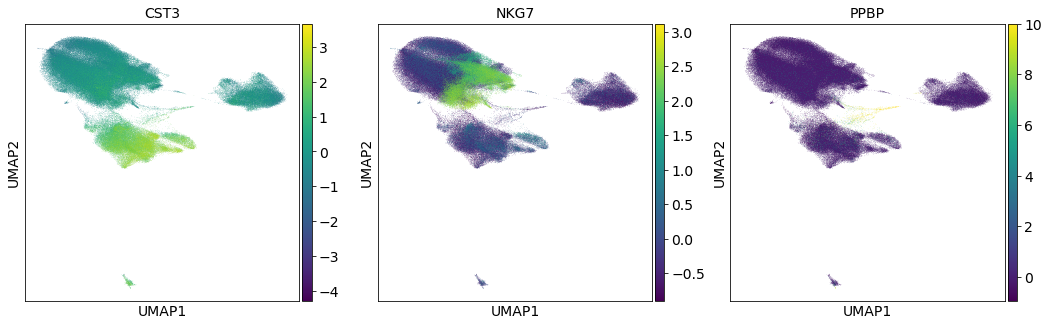

In [48]:
#-- plot the scaled and corrected gene expression
from matplotlib import rcParams
rcParams['figure.figsize'] = (5,5)
sc.pl.umap(adata_Scrub, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:01:47.69) --> found 27 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


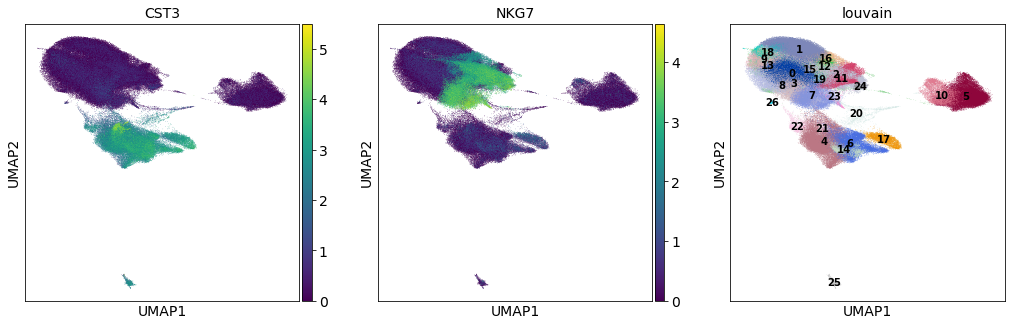

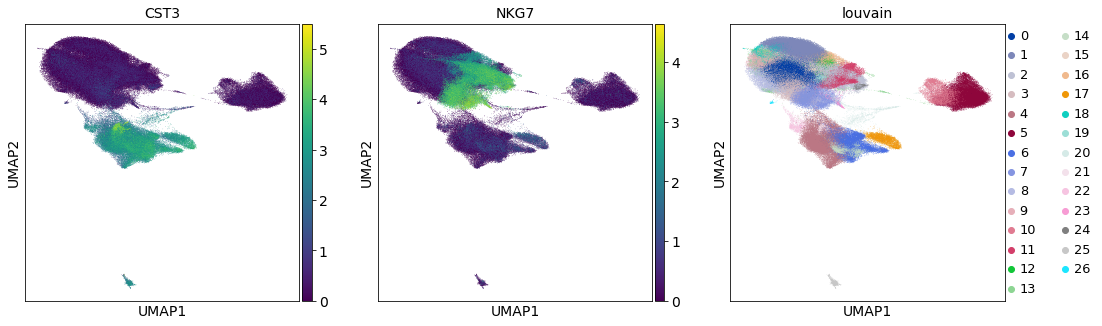

In [51]:
#- Clustering the single-cell graph
sc.tl.louvain(adata_Scrub, resolution=1.2) #resolution=0.3

rcParams['figure.figsize'] = (5,5)
sc.pl.umap(adata_Scrub, color=['CST3', 'NKG7','louvain'], edgecolor='none', size=1, show=True, linewidths=10,legend_loc='on data')
sc.pl.umap(adata_Scrub, color=['CST3', 'NKG7','louvain'], edgecolor='none', size=1, show=True, linewidths=10)


In [52]:
adata_Scrub

AnnData object with n_obs × n_vars = 258868 × 1205 
    obs: 'n_genes', 'total_features_by_counts', 'log1p_total_features_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_features', 'pct_counts_in_top_100_features', 'pct_counts_in_top_200_features', 'pct_counts_in_top_500_features', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts', 'louvain'
    var: 'gene_ids', 'n_cells', 'mito', 'mean_counts', 'log1p_mean_counts', 'n_cells_by_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca', 'neighbors', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [53]:
#---------------------------------- save data 
#--- save embeddings + object : 

#-- Before BBKNN Correction (BC)

#— Embbedings 
Emb =adata_Scrub.obsm.to_df()[['X_umap1', 'X_umap2', 'X_umap3']]
Emb.index =adata_Scrub.obs.index

#-- Meta Data 
meta =adata_Scrub.obs
Mat = meta.join(Emb)

Mat.to_csv('./pSLE_MetaEmb_BC_Scrub.csv')
adata_Scrub.write(results_file1)


In [13]:
adata_Scrub.write('./H5AD/pSLEvsHD_Scrub_BC_042519.h5ad')

... storing 'IDs' as categorical
... storing 'Names' as categorical
... storing 'Groups' as categorical
... storing 'Gender' as categorical
... storing 'Batches' as categorical
... storing 'Eth_Race' as categorical
... storing 'SLEDAI' as categorical
... storing 'SLEDAI_1' as categorical
